In [1]:
import pandas as pd
import numpy as np
import timm
import torchvision.transforms as T
import torch
import itertools
from torch.optim import SGD
from transformers import AutoImageProcessor, AutoModel
import torch.nn as nn

from wildlife_tools.train import ArcFaceLoss, BasicTrainer, set_seed
from wildlife_tools.features import DeepFeatures
from wildlife_tools.data import ImageDataset


/home/users/dash/guppies/embeddings/wildlife-tools/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# Load metadata
PT_CSV = '/home/users/dash/guppies/embeddings/wildlife-tools/exploring/top_10_individuals.csv'
PT_images = '/gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks'
PT_storage = '/gws/nopw/j04/iecdt/dash/embeddings'
df = pd.read_csv(PT_CSV)
# df['path'] = df['path'].str.replace('.JPG', '.png', case=False)
# df.to_csv(PT_CSV, index=False)
df.head()

,identity,path,date
0,63498,1706/Lower Lalaja/29A/DCIM/121D7100/DSC_8870.png,2017-06-29
1,63498,1803/LL/26B/123D7100/DSC_3857.png,2018-03-26
2,63498,1804/LL/27B/DSC_5389.png,2018-04-27
3,63498,1802/LL/26B/DSC_0428.png,2018-02-26
4,63498,1806/LL/28A/100D7100/DSC_9352.png,2018-06-28


In [3]:
# Load the MegaDescriptor model
# backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-L-384', pretrained=True, num_classes=0)
# backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', pretrained=True, num_classes=0)


# Load the processor and model
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
backbone = AutoModel.from_pretrained('facebook/dinov2-base')


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:

# Define image transformations
transform = T.Compose([
    T.Resize((224, 224)),  # Resize to match MegaDescriptor-L-384 input
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
transform_dino = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# Create the dataset
# Split dataset into query and database sets
query_df = df.sample(frac=0.2, random_state=42)
database_df = df.drop(query_df.index)

# Create ImageDataset instances
query_dataset = ImageDataset(query_df, root=PT_images, transform=transform)
database_dataset = ImageDataset(database_df, root=PT_images, transform=transform)

In [5]:
# Define a wrapper to extract features
class DINOv2Wrapper(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone

    def forward(self, x):
        # Extract the last hidden state
        outputs = self.backbone(x)
        # Use the [CLS] token representation
        return outputs.last_hidden_state[:, 0]

In [ ]:

# Define the loss function
objective = ArcFaceLoss(
    num_classes=database_dataset.num_classes,
    embedding_size=backbone.num_features,
    margin=0.5,
    scale=64
)

# Define the optimizer
params = itertools.chain(backbone.parameters(), objective.parameters())
optimizer = SGD(params=params, lr=0.001, momentum=0.9)

# Set the seed for reproducibility
set_seed(0)

# Initialize the trainer
trainer = BasicTrainer(
    dataset=database_dataset,
    model=backbone,
    objective=objective,
    optimizer=optimizer,
    epochs=10,
    device='cuda')

In [50]:
# Start training
trainer.train()

Epoch 9: 100%|████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.74s/it]


In [ ]:
# Save the model's state_dict
torch.save(backbone.state_dict(), PT_storage+'/mgdscrptr_10_epoch.pth')

In [13]:
import pynvml

pynvml.nvmlInit()
device_count = torch.cuda.device_count()
max_free_mem = 0
best_device = 0

for i in range(device_count):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    if mem_info.free > max_free_mem:
        max_free_mem = mem_info.free
        best_device = i

device = torch.device(f'cuda:{best_device}')
print(f'using gpu {device} out of {torch.cuda.device_count()}')

using gpu cuda:2 out of 4


In [14]:
model = DINOv2Wrapper(backbone)
model.to('cuda')

extractor = DeepFeatures(model, device=device)

# Extract features
with torch.no_grad():
    features = extractor(database_dataset)


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.91s/it]


In [15]:
assert len(features) == len(database_dataset)
assert tuple(features.features.shape) == (len(database_dataset), 768)

In [16]:
# Convert embeddings to NumPy array
embeddings = features.features
if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.detach().cpu().numpy()

# Extract labels
labels = features.labels_string  # Assuming labels are stored here

In [17]:
print(labels[:10])  # Print first 10 labels for verification
print(len(set(labels))) #number of individuals
print(embeddings.shape)

['63498' '63498' '63498' '63498' '63498' '63498' '63498' '63498' '63498'
 '63498']
10
(243, 768)


In [18]:
from sklearn.manifold import TSNE

# Determine the number of samples
n_samples = embeddings.shape[0]

# Set perplexity to a value less than n_samples
perplexity_value = min(5, n_samples - 1)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(embeddings)


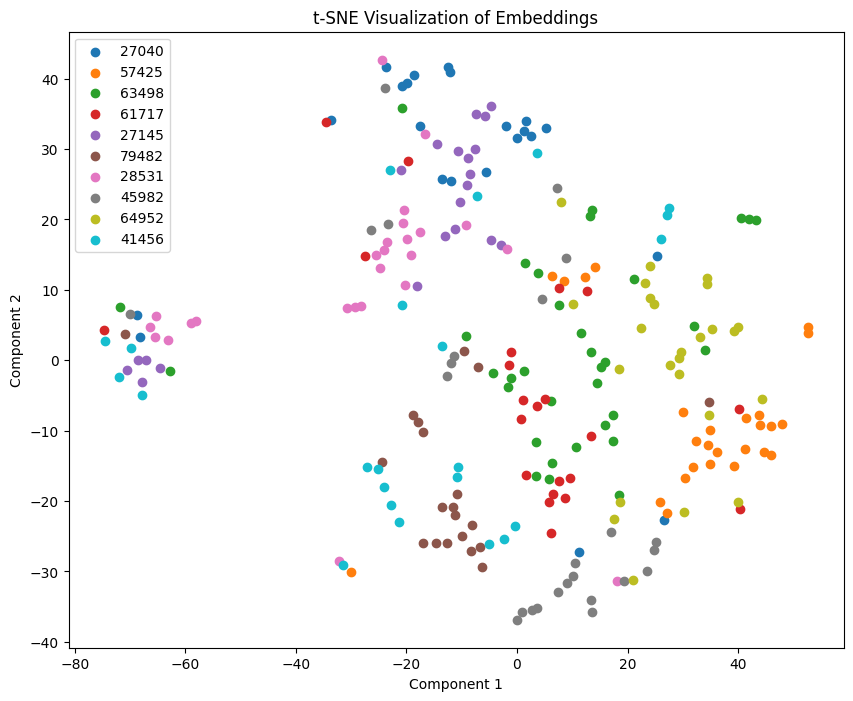

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
unique_labels = set(labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label)

plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [20]:
from wildlife_tools.similarity import CosineSimilarity
from wildlife_tools.inference import KnnClassifier
import numpy as np



# Extract features
query_features = extractor(query_dataset)
database_features = features
# database_features = extractor(database_dataset)

# Compute cosine similarity
similarity_function = CosineSimilarity()
similarity = similarity_function(query_features, database_features)

# Perform 1-NN classification
classifier = KnnClassifier(k=1, database_labels=database_dataset.labels_string)
predictions = classifier(similarity)

# Evaluate accuracy
accuracy = np.mean(np.array(query_dataset.labels_string) == np.array(predictions))
print(f'1-NN Classification Accuracy: {accuracy:.2%}')


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]

1-NN Classification Accuracy: 55.74%


In [21]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings)
# Initialize dictionaries to hold similarities
same_identity_sims = defaultdict(list)
different_identity_sims = defaultdict(list)

num_embeddings = len(embeddings)

for i in range(num_embeddings):
    for j in range(i + 1, num_embeddings):
        sim = similarity_matrix[i][j]
        if labels[i] == labels[j]:
            same_identity_sims[labels[i]].append(sim)
        else:
            key = f"{labels[i]} vs {labels[j]}"
            different_identity_sims[key].append(sim)

# Compute average similarities
avg_same_identity_sim = np.mean([np.mean(sims) for sims in same_identity_sims.values()])
avg_different_identity_sim = np.mean([np.mean(sims) for sims in different_identity_sims.values()])

print(f"Average similarity within the same identity: {avg_same_identity_sim:.4f}")
print(f"Average similarity between different identities: {avg_different_identity_sim:.4f}")

Average similarity within the same identity: 0.9192
Average similarity between different identities: 0.9064


In [22]:
print(same_identity_sims.values())
print(different_identity_sims.values())

dict_values([[np.float32(0.9229777), np.float32(0.8848299), np.float32(0.93911374), np.float32(0.9636324), np.float32(0.9122678), np.float32(0.9457472), np.float32(0.9009534), np.float32(0.9216796), np.float32(0.914767), np.float32(0.9267752), np.float32(0.9460684), np.float32(0.958499), np.float32(0.95091474), np.float32(0.946458), np.float32(0.92140853), np.float32(0.9199853), np.float32(0.955111), np.float32(0.9504824), np.float32(0.92776513), np.float32(0.9317068), np.float32(0.91784704), np.float32(0.9579909), np.float32(0.89827716), np.float32(0.9303006), np.float32(0.9410443), np.float32(0.9424835), np.float32(0.93425775), np.float32(0.92860997), np.float32(0.9270774), np.float32(0.89113337), np.float32(0.92952883), np.float32(0.95987266), np.float32(0.93127155), np.float32(0.8922982), np.float32(0.93225604), np.float32(0.9389955), np.float32(0.9033521), np.float32(0.90626216), np.float32(0.8736347), np.float32(0.9221853), np.float32(0.9107156), np.float32(0.9095671), np.float32

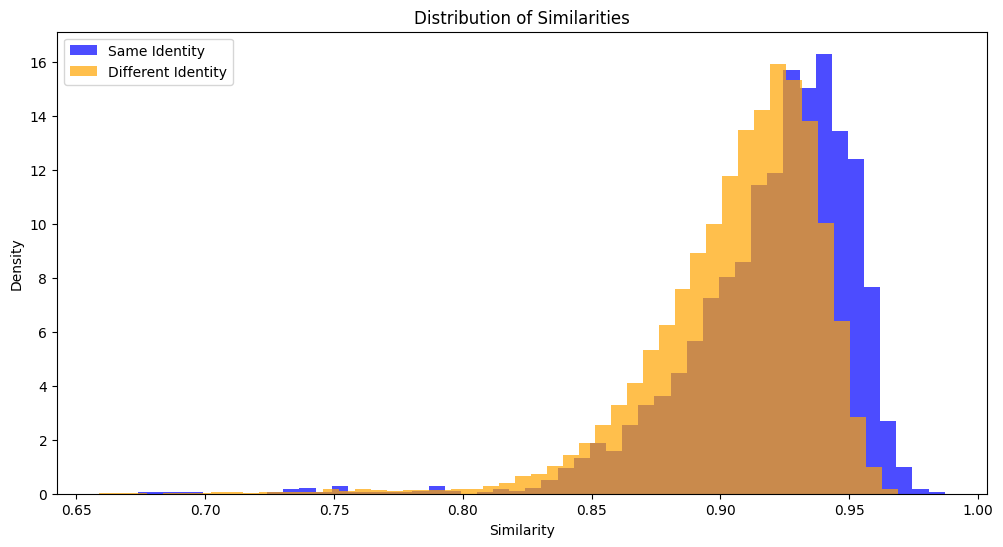

In [23]:
plt.figure(figsize=(12, 6))

# Flatten the lists of similarities
same_identity_flat = [sim for sims in same_identity_sims.values() for sim in sims]
different_identity_flat = [sim for sims in different_identity_sims.values() for sim in sims]

# Plot histograms
plt.hist(same_identity_flat, bins=50, alpha=0.7, label='Same Identity', color='blue', density=True)
plt.hist(different_identity_flat, bins=50, alpha=0.7, label='Different Identity', color='orange', density=True)

# Add labels and legend
plt.title('Distribution of Similarities')
plt.xlabel('Similarity')
plt.ylabel('Density')
plt.legend()

plt.show()

# euclidean distance

In [24]:
from scipy.spatial.distance import cdist

# Calculate pairwise distances
distances = cdist(embeddings, embeddings, metric='euclidean')

print(distances)

[[ 0.         19.010678   23.20765742 ... 17.13117249 16.63723233
  19.00716777]
 [19.010678    0.         22.38662341 ... 17.38209725 18.970074
  22.42184833]
 [23.20765742 22.38662341  0.         ... 21.09492484 21.99415328
  25.21105984]
 ...
 [17.13117249 17.38209725 21.09492484 ...  0.         13.91868612
  18.24691614]
 [16.63723233 18.970074   21.99415328 ... 13.91868612  0.
  18.0277648 ]
 [19.00716777 22.42184833 25.21105984 ... 18.24691614 18.0277648
   0.        ]]


In [25]:
from sklearn.preprocessing import MinMaxScaler

# Normalize distances using Min-Max scaling
scaler = MinMaxScaler()
normalized_distances = scaler.fit_transform(distances)

print(normalized_distances)
# can see that identity a images are close, b are kinda far. but a and b are far from one another!

[[0.         0.5786551  0.60897379 ... 0.49269597 0.46589567 0.54233374]
 [0.57370754 0.         0.58742969 ... 0.49991261 0.53122269 0.63976522]
 [0.70036472 0.68141356 0.         ... 0.60669428 0.61590657 0.71935012]
 ...
 [0.5169875  0.52908366 0.55353524 ... 0.         0.38976769 0.52064139]
 [0.50208129 0.57741917 0.57713119 ... 0.40030421 0.         0.51438832]
 [0.57360161 0.68248575 0.66154349 ... 0.52478498 0.50483502 0.        ]]


In [26]:
avg_same = np.mean([normalized_distances[i][j] for i in range(len(labels)) for j in range(len(labels)) if labels[i] == labels[j]])
avg_diff = np.mean([normalized_distances[i][j] for i in range(len(labels)) for j in range(len(labels)) if labels[i] != labels[j]])
print(f"Average normalized distance within the same identity: {avg_same:.4f}")
print(f"Average normalized distance between different identities: {avg_diff:.4f}")

Average normalized distance within the same identity: 0.5316
Average normalized distance between different identities: 0.5986


In [27]:
from wildlife_tools.inference import KnnClassifier

# Perform 1-NN classification using distances
distance_classifier = KnnClassifier(k=1, database_labels=database_dataset.labels_string, metric='euclidean')
distance_predictions = distance_classifier(normalized_distances)

# Evaluate accuracy
distance_accuracy = np.mean(np.array(query_dataset.labels_string) == np.array(distance_predictions))
print(f'1-NN Classification Accuracy (using distances): {distance_accuracy:.2%}')

TypeError: KnnClassifier.__init__() got an unexpected keyword argument 'metric'